# Collaborations

This page focuses on aspects of collaboration, like co-authorship or co-editorship, in the *Bibliographie sur le XVIIIe siècle*. 

In [1]:
# === Imports === 

import re 
import seaborn as sns
from matplotlib import pyplot as plt
from os.path import join, abspath, normpath, realpath
import os
from lxml import etree
from io import StringIO, BytesIO
from collections import Counter
import pandas as pd
import netgraph


# === Namespaces === 

namespaces = {
    "foaf" : "http://xmlns.com/foaf/0.1/",
    "bib" : "http://purl.org/net/biblio#",
    "dc" : "http://purl.org/dc/elements/1.1/",
    "z" : "http://www.zotero.org/namespaces/export#",
    "rdf" : "http://www.w3.org/1999/02/22-rdf-syntax-ns#"
    }


# === Files and parameters === 

wdir = join("/", "media", "christof", "Data", "Github", "christofs", "BIB18")
bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF.rdf") 
#bibdatafile = join(wdir, "data", "BIB18_Zotero-RDF_TEST.rdf") 
graphviz_file = join(wdir, "figures", "collaboration_coeditors-network.svg") 


# === Load the dataset === 

def read_xml(bibdatafile): 
    bibdata = etree.parse(bibdatafile)
    return bibdata

bibdata = read_xml(bibdatafile)

## Number of collaborators in co-authorship and co-editorship

This section determines how frequent collaborations (co-authorship, co-editorship) are. This is based on the number of "Person" elements within the "authors" or "editors" element. 

Note an important caveat of the data: Any time a book section in an edited volume is cited, the editors of this volume are included in the dataset. This unduly inflates the number of cases of co-editorship and will need to be resolved in a future iteration of this research by counting any edited volume only once, independently of the number of chapters from the volume mentioned in the dataset.  

There are 56860 instances of Element 'authors' in the dataset.


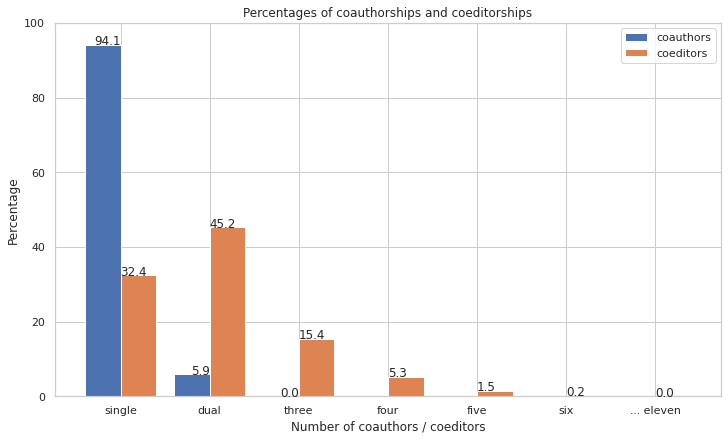

In [94]:
def get_number_collaborators(bibdata): 
    """
    Finds out how frequent collaborations (co-authorship, co-editorship) are.
    Number of "Person" elements within "authors" or "editors" element. 
    """
    # Find all instances of authors
    num_coauthors = []
    xpath = "//bib:authors"
    authors = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(authors)) +  " instances of Element 'authors' in the dataset.")
    num_coauthors = []
    for item in authors:
        #print(item)
        xpath = "rdf:Seq/rdf:li/foaf:Person"
        coauthors = item.xpath(xpath, namespaces=namespaces)
        num_coauthors.append(len(coauthors))
    num_coauthors_counts = Counter(num_coauthors)
    #print(num_coauthors_counts)

    # Calculate percentages
    num_coauthors_perc = {}
    total = sum(num_coauthors_counts.values())
    for key,val in num_coauthors_counts.items():
        #num_coauthors_perc[key] = str(round(val/total * 100, 3)) + '%'
        num_coauthors_perc[key] = round(val/total * 100, 1)
    #print(num_coauthors_perc)

    # Find all instances of editors
    num_coeditors = []
    xpath = "//bib:editors"
    editors = bibdata.xpath(xpath, namespaces=namespaces)
    print("In addition, there are " + str(len(editors)) +  " instances of Element 'editors' in the dataset.")
    num_coeditors = []
    for item in editors:
        xpath = "rdf:Seq/rdf:li/foaf:Person"
        coeditors = item.xpath(xpath, namespaces=namespaces)
        num_coeditors.append(len(coeditors))
    num_coeditors_counts = Counter(num_coeditors)
    #print(dict(num_coeditors_counts))

    # Calculate percentages
    num_coeditors_perc = {}
    total = sum(num_coeditors_counts.values())
    for key,val in num_coeditors_counts.items():
        #num_coeditors_perc[key] = str(round(val/total * 100, 2)) + '%'
        num_coeditors_perc[key] = round(val/total * 100, 1)
    #print(num_coeditors_perc)
    
    return num_coauthors_perc, num_coeditors_perc



def visualize_coauthorship(coauthors, coeditors): 
    # Prepare the data 
    coauthors = pd.Series(coauthors)
    #print(coauthors)
    coeditors = pd.Series(coeditors)
    #print(coeditors)
    collaborations = pd.concat([coauthors, coeditors], axis=1)
    collaborations.rename(columns={0 : "coauthors", 1 : "coeditors"}, inplace=True)
    collaborations = collaborations.fillna(0)
    #print(collaborations)
    
    import numpy as np
    fig, ax = plt.subplots(layout='constrained', figsize = (10,6))
    X_axis = np.arange(7)
    Y_axis = np.arange(7)
    collaboration_labels = ["single", "dual", "three", "four", "five", "six", "... eleven"]
    plt.bar(X_axis - 0.2, collaborations["coauthors"], 0.4, label = 'coauthors')
    plt.bar(Y_axis + 0.2, collaborations["coeditors"], 0.4, label = 'coeditors')
    plt.ylim([0, 100])
    plt.xlabel("Number of coauthors / coeditors")
    plt.ylabel("Percentage")
    plt.title("Percentages of coauthorships and coeditorships")    
    ax.set_xticks(np.arange(7), collaboration_labels)
    ax.legend(loc='upper right')
    
    # function to add value labels
    def addlabels_a(x,y):
        for i in range(len(x)):
            if x[i] in ["single", "dual", "three"]: 
                plt.text(i, y[i], y[i], ha = "right")
    def addlabels_e(x,y):
        for i in range(len(x)):
            plt.text(i, y[i], y[i], ha = "left")
    addlabels_a(collaboration_labels, list(collaborations["coauthors"]))
    addlabels_e(collaboration_labels, list(collaborations["coeditors"]))
    

    
coauthors, coeditors = get_number_collaborators(bibdata) 
visualize_coauthorship(coauthors, coeditors)


Regarding authorship (of books, articles and chapters), the figure above shows that single authorship is clearly the norm in this dataset (with around 94% of the cases). The remaining 6% are cases of dual authorship. There are no cases of multiple authorship beyond the constellation of dual authorship. 

In contrast, when looking at editorship (of edited volumes or editions), joint editorship with two editors is the most common case (with around 45% of the cases). Single editorship, however, is also widespread (with 32%) and triple co-editorship not uncommon (with 15%). There is one notable outlier in the dataset, with a title being edited by 11 co-editors. 

It could be interesting to distinguish between editorship of edited volumes on the one hand, and textual editions, on the other hand. This is future work. 

## Collaborator networks

Builds the data for a network of people having collaborated as editors.

In [96]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


coeditorcounts_top_file = join(wdir, "results", "coeditor-counts_top.csv")
coeditorcounts_full_file = join(wdir, "results", "coeditor-counts_full.csv")


def network_coeditors(bibdata): 
    """
    Builds the data for a network of people having collaborated as editors. 
    """
    # Find all instances of editors
    xpath = "//bib:editors"
    editors = bibdata.xpath(xpath, namespaces=namespaces)
    print("There are " + str(len(editors)) + " editors (i.e., instances of Element 'editors').")

    # Collect the names of each person within each editors element
    coeditors = []
    for item in editors:
        xpath = "rdf:Seq/rdf:li/foaf:Person"
        coeditors_elements = item.xpath(xpath, namespaces=namespaces)
        coeditors_names = []
        # Get the names (full name or first name, last name) from each person
        for item in coeditors_elements: 
            if len(item) == 2: 
                coeditors_names.append(item[0].text + ", " + item[1].text)
        coeditors.append(coeditors_names)

    # Establish the count of each collaboration between editors
    import itertools 
    all_coeditor_combinations = []
    for item in coeditors: 
        coeditor_combinations = list(itertools.combinations(item, 2))
        coeditor_combinations = [tuple(sorted(item)) for item in coeditor_combinations]
        for coedcomb in coeditor_combinations: 
            all_coeditor_combinations.append(coedcomb)
    ccc = dict(Counter(all_coeditor_combinations)) # ccc = coeditor_combinations_count

    # Transform to a DataFrame
    ccc = pd.DataFrame.from_dict(ccc, orient="index", columns=["count"])
    ccc = ccc.reset_index()
    ccc_split = pd.DataFrame(ccc["index"].tolist())
    ccc_merged = ccc_split.merge(ccc, left_index=True, right_index=True)
    ccc = ccc_merged.drop(["index"], axis=1)
    ccc = ccc.rename({0 : "coeditor1", 1 : "coeditor2"}, axis=1)
    ccc = ccc.sort_values(by="count", ascending=False)
    #print(ccc.head())
    #print(ccc.shape, "shape of dataframe")
    with open(join(coeditorcounts_full_file), "w", encoding="utf8") as outfile: 
        ccc.to_csv(outfile, sep=";")

    # Filter the DataFrame to make it manageable for visualization
    # Determine the top N most frequent co-editors
    coeditors_top = list(set(list(ccc.head(20).loc[:,"coeditor1"]) +\
        list(ccc.head(20).loc[:,"coeditor2"])))
    #print(coeditors_top)
    print("Among all editors, " + str(len(coeditors_top)) + " have been selected as the most active co-editors.")
    # Filter the DataFrame to include just the collaborations involving at least one of the top co-editors. 
    # The resulting DataFrame will have all collaborations between the top co-editors and their co-editors. 
    ccc_filtered = ccc[(ccc["coeditor1"].isin(coeditors_top)) |\
                       (ccc["coeditor2"].isin(coeditors_top))]
    #print(ccc_filtered.shape, "shape of dataframe of top co-editors and their co-editors.")
    # Simplify the labels 
    #ccc_filtered = ccc_filtered.replace(' .*?]', '',regex=True).astype(str)
    ccc_filtered.loc[:,'coeditor1'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor1']]
    ccc_filtered.loc[:,'coeditor2'] =  [re.sub(r', .*','', str(x)) for x in ccc_filtered.loc[:,'coeditor2']]
    print("The following table shows the 5 most active pairs of editors.\n")
    print(ccc_filtered.head())
    with open(join(coeditorcounts_top_file), "w", encoding="utf8") as outfile: 
        ccc_filtered.to_csv(outfile, sep=";")

network_coeditors(bibdata)

There are 17135 editors (i.e., instances of Element 'editors').
Among all editors, 20 have been selected as the most active co-editors.
The following table shows the 5 most active pairs of editors.

         coeditor1  coeditor2  count
1848        Herman  Pelckmans    221
3896       Hasquin    Mortier    103
2546  Ferreyrolles    Versini     84
184          Biard    Leuwers     78
183          Biard    Bourdin     64


## Co-editor network

In [ ]:
import matplotlib.pyplot as plt
from netgraph import Graph

def load_data(coeditorcounts_top_file):
    # Load the data from file
    with open(join(coeditorcounts_top_file), "r", encoding="utf8") as infile: 
        ccc = pd.read_csv(infile, sep=";", index_col=0)
    #print(ccc.head())
    return ccc


def create_plot(ccc): 
    # Get edges (without weights)
    edges = ccc.loc[:,["coeditor1", "coeditor2"]].to_records(index=False).tolist()
    #print(edges)
    weights = ccc.loc[:,"count"].tolist()
    #print(weights)
    edgeweights = dict(zip(edges, weights))
    #print(edgeweights)
           
    # Calculate the layout
    positions = netgraph.get_fruchterman_reingold_layout(
        edges, 
        edgeweights, 
        k = None, 
        origin = (0, 0), 
        scale = (2, 2), 
        pad_by = 0.05, 
        initial_temperature = 2.0, 
        total_iterations = 100, 
        node_size = 0.5, 
        node_positions = None, 
        fixed_nodes = None
        )

    # Plot the data
    ccc = ccc.to_records(index=False).tolist() # Transform to list of tuples
    fig, ax = plt.subplots(figsize=(20, 20))
    cmap = 'RdGy'
    Graph(
        ccc, 
        edge_cmap = cmap, 
        edge_width = 2., 
        arrows = False,
        node_labels = True,
        node_label_offset = 0.005,
        node_layout = positions,
        edge_layout = 'bundled',
        
        node_label_fontdict = dict(
            #fontweight="bold",
            fontsize = 8,
            )
        )
    plt.savefig(graphviz_file, dpi=300)
    


ccc = load_data(coeditorcounts_top_file)
create_plot(ccc)


## Co-editor networks 

As shown above, editorship is an area of particularly intense collaboration in the community of Dix-huitiémistes, based on the data in the bibliography. The following is an initial, experimental attempt to elucidate the data using network visualization. 

The following shows a network of the top 20 co-editors and all of their co-editors, resulting in 148 different co-editor pairs. Each node is one editor, and each time two people have co-edited a publication, a link between them is created. The more co-editorships a person accumulates, the larger the node. The more co-editorships two people share, the thicker the edge connecting them. For this visualization, the full data of collaborations for edited volumes and editions has been massively reduced. Different parameters may strongly affect the results. See the full coeditor data in the `data` folder for more details.  

![Network showing the top 20 co-editors and all of their co-editors, created using Gephi.](figures/coeditors_top2.svg)

This figure is available also as a [zoom-able image file](/figures/coeditors_top2.svg) and [with somewhat friendlier colors but no community detection](/figures/coeditors_top1.svg).  

We basically see three key co-editor networks (the different colors are based on an algorithmic community or cluster detection): 

- Porret, Rosset, Majeur, Farkas, Baczko et al. 
- Sermain, Herman, Pelckmans, Escola, Omacini, Peeters, Paschoud, Berchtold et al. 
- Leuwers, Bourdin, Biard, Simien, Serna, Antoine et al. 
- Smaller clusters with Didier and Neefs as well around Kolving and Mortier. 

Some initial observations: While Porret appears to be the most productive co-editor overall, this is achived with some frequent, but also with a large number of less frequent coeditors. Inversely, the most intense collaboration appears to be between Herman and Pelckmans, who seem to avoid one-off collaborations. Finally, Rosset also functions as a bridge linking Porret and Baczko on the one hand, and Herman and Pelckmans on the other hand, and their respective coeditor networks. No similar bridge exists towards the Leuwers et al. network. The smaller Didier cluster is also connected to Sermain.  
